# Option 2: Geological Image Simalarity

## BACKGROUND
A geology research company wants to create a tool for identifying interesting patterns in their imagery data. This tool will possess a search capability whereby an analyst provides an image of interest and is presented with other images which are similar to it.
## GOAL
Your task is to create the machine learning component for this image similarity application. The machine learning
model should return the top K images that are most similar to this image based on a single image input.
## DATA
Link to data: https://www.kaggle.com/tanyadayanand/geological-image-similarity

In [4]:
from collections import defaultdict
from pathlib import Path
from PIL import Image
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow_datasets as tfds
import sys
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


sys.path.append("..")
DATA_DIR = os.path.abspath('../data')

In [5]:
print(tf.__version__)

2.4.1


## Data Loading

The dataset we downloaded contains images of 6 types of patterns:

1. andesite
2. gneiss
3. marble
4. quartzite
5. rhyolite
6. schist

So, let's create the labels for these 6 classes: 

In [6]:
!ls ../data/geological_similarity
print('Confirm that we have 6 classes on the downloaded dataset')

ls: ../data/geological_similarity: No such file or directory
Confirm that we have 6 classes on the downloaded dataset


In [9]:
data_dir = Path('../data/raw/geoimage/geological_similarity')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'There are {image_count} total images')

There are 29998 total images


## Generate a Dataset

In [15]:
image_size =(28, 28)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 29998 files belonging to 6 classes.
Using 23999 files for training.
Found 29998 files belonging to 6 classes.
Using 5999 files for validation.


## Visualize the data

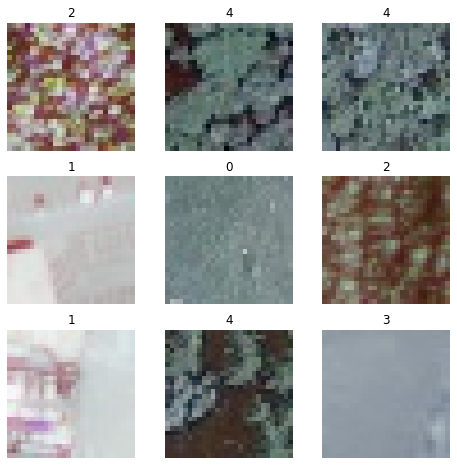

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [17]:
for image, label in train_ds.take(1):
    print(f'image shape: {image.shape}')
    print(f'label shape: {label.shape}')

image shape: (32, 28, 28, 3)
label shape: (32,)


In [ ]:
train_labels, train_images = [], []
for image, label in tfds.as_numpy(train_ds):

    train_labels = np.append(train_labels, label)
    train_images.extend(image)

In [19]:
val_labels, val_images = [], []
for image, label in tfds.as_numpy(val_ds):

    val_labels = np.append(val_labels, label)
    val_images.extend(image)

In [20]:
train_images = np.array(train_images).astype('float32') / 255.
val_images = np.array(val_images).astype('float32') / 255.

In [21]:
val_labels = val_labels.astype(np.int64)
class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(val_labels):
    class_idx_to_test_idxs[y].append(y_test_idx)

In [22]:
val_labels

array([4, 1, 5, ..., 2, 4, 1])

## Autoencoder

In [23]:
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 3)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder()

In [24]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(train_images, train_images,
                epochs=10,
                shuffle=True,
                validation_data= (val_images, val_images))

Epoch 1/10
750/750 [==============================] - 25s 33ms/step - loss: 0.0142 - val_loss: 0.0041
Epoch 2/10
750/750 [==============================] - 25s 34ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 3/10
750/750 [==============================] - 25s 33ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 4/10
750/750 [==============================] - 25s 33ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 5/10
750/750 [==============================] - 25s 33ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 6/10
750/750 [==============================] - 25s 34ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 7/10
750/750 [==============================] - 25s 33ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/10
541/750 [====================>.........] - ETA: 6s - loss: 0.0030

In [ ]:
autoencoder.encoder.summary()

In [ ]:
autoencoder.decoder.summary()

In [ ]:
embeddings = autoencoder.encoder(val_images).numpy()

In [ ]:
embeddings.shape

In [ ]:
def similar_images(num_images,  test_index, test_dataset, metric = "euclidean"):
    image_tensor = test_dataset[test_index]
    tmp = np.delete(test_dataset, test_index, 0)
    knn = NearestNeighbors(n_neighbors=10, metric=metric)
    knn.fit(tmp)
    _, indices = knn.kneighbors(np.array([image_tensor]))
    return indices

In [ ]:
num_classes, height_width = 6, 28
num_collage_examples, near_neighbors_per_example = 5, 10
examples = np.empty(
    (
        num_collage_examples,
        near_neighbors_per_example + 1,
        height_width,
        height_width,
        3,
    ),
    dtype = np.float32
)

In [ ]:
val_x = embeddings.reshape((embeddings.shape[0], -1))

In [ ]:
for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = val_images[row_idx]
    anchor_near_neighbors = similar_images(near_neighbors_per_example, row_idx, val_x)
    tmp = anchor_near_neighbors.tolist()[0] 

    for col_idx, nn_idx in enumerate(tmp):
        examples[row_idx, col_idx+1] = val_images[nn_idx]

In [ ]:
def show_collage(exxamples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]
    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows *box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx*box_size, row_idx * box_size)
            )
    collage = collage.resize((4*num_cols*box_size, 4 *num_rows *box_size))
    
    return collage

In [ ]:
show_collage(examples)

In [ ]:
confusion_matrix = np.zeros((num_classes, num_classes))
# For each class.
for class_idx in range(num_classes):
    # Consider 10 examples.
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        anchor_near_neighbors = similar_images(near_neighbors_per_example, y_test_idx,val_x)
        for nn_idx in anchor_near_neighbors:
            nn_class_idx = val_labels[nn_idx]
#             print(class_idx, nn_class_idx)
            confusion_matrix[class_idx, nn_class_idx] += 1
labels = [
    "andesite",
    "gneiss",
    "marble",
    "quartzite",
    "rhyolite",
    "schist",
]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()